In [1]:
import pandas as pd
import numpy as np
from itertools import product
import xgboost as xgb
import pickle
import gc

In [2]:
#lags=[1,3,6,9,12]
lags=[2,4,5,7,8]

In [3]:
sales = pd.read_csv('data/sales_train_v2.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [4]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    # all unique shop id for the block_num month
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    # all unique item id for the block_num month
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    # append cartesian product of all unique shop id and item id that occur in  block_num month
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [6]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum','item_price': np.mean})
# Rename item_cnt_day column as target
gb.rename({'item_cnt_day':'target'}, axis='columns',inplace=True)

In [7]:
# Join it to the grid
# Any shop/item combinations with no target means it has no sale, so fill with 0
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [8]:
# Generate test data
# Test month is 34
test['date_block_num'] = 34
test.drop(columns=['ID'], inplace=True)
test = downcast_dtypes(test)
test.head()# Delete grid and gb to save memory

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [9]:
# Delete grid and gb to save memory
del grid,gb
gc.collect()

56

In [10]:
all_data = pd.merge(all_data, items, how='left', on='item_id')
all_data = pd.merge(all_data, item_categories, how='left', on='item_category_id')
all_data = pd.merge(all_data, shops, how='left', on='shop_id')

In [11]:
# add revenue
all_data['revenue'] = all_data['item_price'] * all_data['target']

In [12]:
# drop item_name, item_category_name and shop_name to save memory
# Unlikely to have sufficient memory to utilise these feature
all_data.drop(columns=['item_name','item_category_name','shop_name'],inplace=True)
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,item_price,item_category_id,revenue
0,59,22154,0,1.0,999.0,37,999.0
1,59,2552,0,0.0,0.0,58,0.0
2,59,2554,0,0.0,0.0,58,0.0
3,59,2555,0,0.0,0.0,56,0.0
4,59,2564,0,0.0,0.0,59,0.0


In [13]:
test = pd.merge(test, items, how='left', on='item_id')
test = pd.merge(test, item_categories, how='left', on='item_category_id')
test = pd.merge(test, shops, how='left', on='shop_id')

In [14]:
test.drop(columns=['item_name','item_category_name','shop_name'],inplace=True)
test = downcast_dtypes(test)
test.head()

,shop_id,item_id,date_block_num,item_category_id
0,5,5037,34,19
1,5,5320,34,55
2,5,5233,34,19
3,5,5232,34,23
4,5,5268,34,20


In [15]:
df = all_data
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For all_data")
print(df_missing_col)

Missing Values per Column For all_data
shop_id             0.0
item_id             0.0
date_block_num      0.0
target              0.0
item_price          0.0
item_category_id    0.0
revenue             0.0
dtype: float64


In [16]:
df = test
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For test")
print(df_missing_col)

Missing Values per Column For test
shop_id             0.0
item_id             0.0
date_block_num      0.0
item_category_id    0.0
dtype: float64


In [17]:
# Merge all_data and test to add mean encodings
combined_data = pd.concat([all_data,test],axis=0)
combined_data.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target
0,0,37,22154,999.0,999.0,59,1.0
1,0,58,2552,0.0,0.0,59,0.0
2,0,58,2554,0.0,0.0,59,0.0
3,0,56,2555,0.0,0.0,59,0.0
4,0,59,2564,0.0,0.0,59,0.0


In [18]:
combined_data.tail()

,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target
214195,34,55,18454,NaN,NaN,45,NaN
214196,34,64,16188,NaN,NaN,45,NaN
214197,34,55,15757,NaN,NaN,45,NaN
214198,34,40,19648,NaN,NaN,45,NaN
214199,34,37,969,NaN,NaN,45,NaN


# Add Mean Encodings

In [19]:
# Add mean encodings
col_to_enc = [['item_id','date_block_num'], ['shop_id','date_block_num'], ['item_category_id','date_block_num'],\
                ['item_id','shop_id','date_block_num'], ['shop_id','item_category_id','date_block_num']]

val_to_enc = [['target'],['item_price'],['revenue']]
combined_data_copy = combined_data.copy()

for lag in lags:
    combined_data_copy['date_block_num'] = combined_data['date_block_num'] + lag
    for col in col_to_enc:
        for val in val_to_enc:
            mean_df = combined_data_copy[col + val].groupby(col).agg(np.mean).reset_index()
            mean_df.rename(
                {val[0]: "mean_of_"+val[0]+"_groupby_"+"_".join(col)+"_"+str(lag)+"_months_ago"},
                axis='columns', inplace=True
            )
            combined_data = pd.merge(combined_data, mean_df, on=col, how='left')

In [20]:
combined_data.head()

,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,...,mean_of_revenue_groupby_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago
0,0,37,22154,999.0,999.0,59,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,58,2552,0.0,0.0,59,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,58,2554,0.0,0.0,59,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,56,2555,0.0,0.0,59,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2564,0.0,0.0,59,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#split back into all_data and test
all_data = combined_data[combined_data['date_block_num'] < 34]
test = combined_data[combined_data['date_block_num'] == 34]

In [22]:
test.reset_index(inplace=True)
#test.drop(columns=['index','item_cnt_month', 'ID'],inplace=True)
test.drop(columns=['index'],inplace=True)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
test.head()

,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,...,mean_of_revenue_groupby_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago
0,34,19,5037,NaN,NaN,5,NaN,2.558140,627.844421,2300.844727,...,160.351273,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459
1,34,55,5320,NaN,NaN,5,NaN,NaN,NaN,NaN,...,160.351273,0.260196,54.843975,79.367989,NaN,NaN,NaN,0.188679,46.208897,57.560646
2,34,19,5233,NaN,NaN,5,NaN,1.860465,490.181671,1303.220459,...,160.351273,0.429837,379.973938,676.201599,NaN,NaN,NaN,0.322751,326.248688,497.026459
3,34,23,5232,NaN,NaN,5,NaN,1.116279,420.873260,785.085266,...,160.351273,0.448420,383.406830,662.227234,NaN,NaN,NaN,0.273292,225.169250,351.322968
4,34,20,5268,NaN,NaN,5,NaN,NaN,NaN,NaN,...,160.351273,1.318759,1094.776611,4614.581543,NaN,NaN,NaN,0.629214,669.105286,2192.475586


In [24]:
if lags == [1,3,6,9,12]:
    # remove first 12 months (0 to 11)from all_data since there will be alot of NaNs
    all_data = all_data[all_data['date_block_num'] > 11]
elif lags == [2,4,5,7,8]:
    # remove first 8 months (0 to 7)from all_data since there will be alot of NaNs
    all_data = all_data[all_data['date_block_num'] > 7]
all_data.head()

,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,...,mean_of_revenue_groupby_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago
3010733,8,40,947,37.0,37.0,51,1.0,0.086957,12.956522,12.956522,...,115.819069,0.310860,35.657887,80.455750,0.0,0.0,0.0,0.379282,31.052006,56.944027
3010734,8,77,716,91.0,91.0,51,1.0,0.413043,27.891304,60.282608,...,115.819069,0.248579,25.744238,45.926048,NaN,NaN,NaN,0.441860,26.930233,45.790699
3010735,8,73,687,248.0,248.0,51,1.0,0.652174,208.695648,391.304352,...,115.819069,0.835802,631.809998,1631.507202,1.0,248.0,248.0,0.333333,277.111115,284.000000
3010736,8,45,410,89.0,89.0,51,1.0,0.195652,41.913044,41.913044,...,115.819069,0.108824,22.178104,27.226471,1.0,89.0,89.0,0.338235,30.029411,44.691177
3010737,8,45,308,89.0,89.0,51,1.0,0.152174,37.891304,37.891304,...,115.819069,0.108824,22.178104,27.226471,0.0,0.0,0.0,0.338235,30.029411,44.691177


In [25]:
# Drop target, item_price and revenue from test
test.drop(columns=['item_price','revenue','target'],inplace=True)
test.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,date_block_num,item_category_id,item_id,shop_id,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,mean_of_target_groupby_shop_id_date_block_num_2_months_ago,mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago,mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago,...,mean_of_revenue_groupby_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago
0,34,19,5037,5,2.558140,627.844421,2300.844727,0.214749,123.394585,231.395111,...,160.351273,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459
1,34,55,5320,5,NaN,NaN,NaN,0.214749,123.394585,231.395111,...,160.351273,0.260196,54.843975,79.367989,NaN,NaN,NaN,0.188679,46.208897,57.560646
2,34,19,5233,5,1.860465,490.181671,1303.220459,0.214749,123.394585,231.395111,...,160.351273,0.429837,379.973938,676.201599,NaN,NaN,NaN,0.322751,326.248688,497.026459
3,34,23,5232,5,1.116279,420.873260,785.085266,0.214749,123.394585,231.395111,...,160.351273,0.448420,383.406830,662.227234,NaN,NaN,NaN,0.273292,225.169250,351.322968
4,34,20,5268,5,NaN,NaN,NaN,0.214749,123.394585,231.395111,...,160.351273,1.318759,1094.776611,4614.581543,NaN,NaN,NaN,0.629214,669.105286,2192.475586


In [26]:
# Check missing values in combined_data
df = all_data
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For all_data")
print(df_missing_col[:41])

Missing Values per Column For all_data
date_block_num                                                                     0.000000
item_category_id                                                                   0.000000
item_id                                                                            0.000000
item_price                                                                         0.000000
revenue                                                                            0.000000
shop_id                                                                            0.000000
target                                                                             0.000000
mean_of_target_groupby_item_id_date_block_num_2_months_ago                         0.224753
mean_of_item_price_groupby_item_id_date_block_num_2_months_ago                     0.224753
mean_of_revenue_groupby_item_id_date_block_num_2_months_ago                        0.224753
mean_of_target_groupby_shop_id_date_block

In [27]:
print(df_missing_col[41:])

mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago                     0.035297
mean_of_revenue_groupby_shop_id_date_block_num_5_months_ago                        0.035297
mean_of_target_groupby_item_category_id_date_block_num_5_months_ago                0.006607
mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago            0.006607
mean_of_revenue_groupby_item_category_id_date_block_num_5_months_ago               0.006607
mean_of_target_groupby_item_id_shop_id_date_block_num_5_months_ago                 0.325675
mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago             0.325675
mean_of_revenue_groupby_item_id_shop_id_date_block_num_5_months_ago                0.325675
mean_of_target_groupby_shop_id_item_category_id_date_block_num_5_months_ago        0.041685
mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago    0.041685
mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_5_months_ago    

In [28]:
if lags == [1,3,6,9,12]:
    # Fill NaNs for price mean encodings with past price mean encodings
    all_data['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'].fillna(0)

    all_data['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_1_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_1_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_1_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_1_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_1_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_1_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_1_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_1_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_1_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_1_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'])

    # fill rest of NaNs with 0
    all_data.fillna(0,inplace=True)
elif lags == [2,4,5,7,8]:
    # Fill NaNs for price mean encodings with past price mean encodings
    all_data['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'].fillna(0)
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'].fillna(0)

    all_data['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'])

    all_data['mean_of_item_price_groupby_item_id_date_block_num_2_months_ago'] = all_data['mean_of_item_price_groupby_item_id_date_block_num_2_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'])
    all_data['mean_of_item_price_groupby_item_category_id_date_block_num_2_months_ago'] = all_data['mean_of_item_price_groupby_item_category_id_date_block_num_2_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'])
    all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_2_months_ago'] = all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_2_months_ago'].fillna(all_data['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'])
    all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_2_months_ago'] = all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_2_months_ago'].fillna(all_data['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'])

    # fill rest of NaNs with 0
    all_data.fillna(0,inplace=True)
else:
    print('Use either lags of [1,3,6,9,12] or [2,4,5,7,8]')

In [29]:
# Check missing values in combined_data
df = all_data
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For all_data")
print(df_missing_col[:41])

Missing Values per Column For all_data
date_block_num                                                                     0.0
item_category_id                                                                   0.0
item_id                                                                            0.0
item_price                                                                         0.0
revenue                                                                            0.0
shop_id                                                                            0.0
target                                                                             0.0
mean_of_target_groupby_item_id_date_block_num_2_months_ago                         0.0
mean_of_item_price_groupby_item_id_date_block_num_2_months_ago                     0.0
mean_of_revenue_groupby_item_id_date_block_num_2_months_ago                        0.0
mean_of_target_groupby_shop_id_date_block_num_2_months_ago                         0.0
mean

In [30]:
print(df_missing_col[41:])

mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago                     0.0
mean_of_revenue_groupby_shop_id_date_block_num_5_months_ago                        0.0
mean_of_target_groupby_item_category_id_date_block_num_5_months_ago                0.0
mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago            0.0
mean_of_revenue_groupby_item_category_id_date_block_num_5_months_ago               0.0
mean_of_target_groupby_item_id_shop_id_date_block_num_5_months_ago                 0.0
mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago             0.0
mean_of_revenue_groupby_item_id_shop_id_date_block_num_5_months_ago                0.0
mean_of_target_groupby_shop_id_item_category_id_date_block_num_5_months_ago        0.0
mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago    0.0
mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_5_months_ago       0.0
mean_of_target_groupby_item_id_date_block_n

In [31]:
df = test
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For test")
print(df_missing_col[0:41])

Missing Values per Column For test
date_block_num                                                                     0.000000
item_category_id                                                                   0.000000
item_id                                                                            0.000000
shop_id                                                                            0.000000
mean_of_target_groupby_item_id_date_block_num_2_months_ago                         0.287647
mean_of_item_price_groupby_item_id_date_block_num_2_months_ago                     0.287647
mean_of_revenue_groupby_item_id_date_block_num_2_months_ago                        0.287647
mean_of_target_groupby_shop_id_date_block_num_2_months_ago                         0.023810
mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago                     0.023810
mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago                        0.023810
mean_of_target_groupby_item_category_id_date_

In [32]:
print(df_missing_col[41:])

mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago            0.000980
mean_of_revenue_groupby_item_category_id_date_block_num_5_months_ago               0.000980
mean_of_target_groupby_item_id_shop_id_date_block_num_5_months_ago                 0.399164
mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago             0.399164
mean_of_revenue_groupby_item_id_shop_id_date_block_num_5_months_ago                0.399164
mean_of_target_groupby_shop_id_item_category_id_date_block_num_5_months_ago        0.024767
mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago    0.024767
mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_5_months_ago       0.024767
mean_of_target_groupby_item_id_date_block_num_7_months_ago                         0.418627
mean_of_item_price_groupby_item_id_date_block_num_7_months_ago                     0.418627
mean_of_revenue_groupby_item_id_date_block_num_7_months_ago                     

In [33]:
if lags == [1,3,6,9,12]: 
    # Fill NaNs for price mean encodings with past price mean encodings
    test['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'].fillna(0)

    test['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_12_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_12_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_12_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_12_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_12_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_9_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_9_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_9_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_9_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_9_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_6_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_6_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_6_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_6_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_6_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_1_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_1_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_3_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_1_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_1_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_3_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_1_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_1_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_3_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_1_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_1_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_3_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_1_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_1_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_3_months_ago'])

    # fill rest of NaNs with 0
    test.fillna(0,inplace=True)
elif lags == [2,4,5,7,8]:
     # Fill NaNs for price mean encodings with past price mean encodings
    test['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'].fillna(0)
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'].fillna(0)

    test['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_8_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_8_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_7_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_7_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_7_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_7_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_7_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_5_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_5_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago'])

    test['mean_of_item_price_groupby_item_id_date_block_num_2_months_ago'] = test['mean_of_item_price_groupby_item_id_date_block_num_2_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_date_block_num_4_months_ago'])
    test['mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago'] = test['mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_date_block_num_4_months_ago'])
    test['mean_of_item_price_groupby_item_category_id_date_block_num_2_months_ago'] = test['mean_of_item_price_groupby_item_category_id_date_block_num_2_months_ago'].fillna(test['mean_of_item_price_groupby_item_category_id_date_block_num_4_months_ago'])
    test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_2_months_ago'] = test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_2_months_ago'].fillna(test['mean_of_item_price_groupby_item_id_shop_id_date_block_num_4_months_ago'])
    test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_2_months_ago'] = test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_2_months_ago'].fillna(test['mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_4_months_ago'])

    # fill rest of NaNs with 0
    test.fillna(0,inplace=True)
else:
    print('Use either lags of [1,3,6,9,12] or [2,4,5,7,8]')

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [34]:
df = test
missing_values_per_column = df.isnull().sum(axis=0,skipna=False)
missing_values_per_column /= df.shape[0]
missing_values_per_column = missing_values_per_column.tolist()
df_missing_col = pd.Series(missing_values_per_column, index=df.columns.values)
print("Missing Values per Column For test")
print(df_missing_col[0:41])

Missing Values per Column For test
date_block_num                                                                     0.0
item_category_id                                                                   0.0
item_id                                                                            0.0
shop_id                                                                            0.0
mean_of_target_groupby_item_id_date_block_num_2_months_ago                         0.0
mean_of_item_price_groupby_item_id_date_block_num_2_months_ago                     0.0
mean_of_revenue_groupby_item_id_date_block_num_2_months_ago                        0.0
mean_of_target_groupby_shop_id_date_block_num_2_months_ago                         0.0
mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago                     0.0
mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago                        0.0
mean_of_target_groupby_item_category_id_date_block_num_2_months_ago                0.0
mean_of_

In [35]:
print(df_missing_col[41:])

mean_of_item_price_groupby_item_category_id_date_block_num_5_months_ago            0.0
mean_of_revenue_groupby_item_category_id_date_block_num_5_months_ago               0.0
mean_of_target_groupby_item_id_shop_id_date_block_num_5_months_ago                 0.0
mean_of_item_price_groupby_item_id_shop_id_date_block_num_5_months_ago             0.0
mean_of_revenue_groupby_item_id_shop_id_date_block_num_5_months_ago                0.0
mean_of_target_groupby_shop_id_item_category_id_date_block_num_5_months_ago        0.0
mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_5_months_ago    0.0
mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_5_months_ago       0.0
mean_of_target_groupby_item_id_date_block_num_7_months_ago                         0.0
mean_of_item_price_groupby_item_id_date_block_num_7_months_ago                     0.0
mean_of_revenue_groupby_item_id_date_block_num_7_months_ago                        0.0
mean_of_target_groupby_shop_id_date_block_n

# Add month

In [36]:
all_data['month'] = all_data['date_block_num'] % 12
test['month'] = test['date_block_num'] % 12

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
all_data.head()

,date_block_num,item_category_id,item_id,item_price,revenue,shop_id,target,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,...,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago,month
3010733,8,40,947,37.0,37.0,51,1.0,0.086957,12.956522,12.956522,...,0.310860,35.657887,80.455750,0.0,0.0,0.0,0.379282,31.052006,56.944027,8
3010734,8,77,716,91.0,91.0,51,1.0,0.413043,27.891304,60.282608,...,0.248579,25.744238,45.926048,0.0,0.0,0.0,0.441860,26.930233,45.790699,8
3010735,8,73,687,248.0,248.0,51,1.0,0.652174,208.695648,391.304352,...,0.835802,631.809998,1631.507202,1.0,248.0,248.0,0.333333,277.111115,284.000000,8
3010736,8,45,410,89.0,89.0,51,1.0,0.195652,41.913044,41.913044,...,0.108824,22.178104,27.226471,1.0,89.0,89.0,0.338235,30.029411,44.691177,8
3010737,8,45,308,89.0,89.0,51,1.0,0.152174,37.891304,37.891304,...,0.108824,22.178104,27.226471,0.0,0.0,0.0,0.338235,30.029411,44.691177,8


In [38]:
test.head()

,date_block_num,item_category_id,item_id,shop_id,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,mean_of_target_groupby_shop_id_date_block_num_2_months_ago,mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago,mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago,...,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago,month
0,34,19,5037,5,2.558140,627.844421,2300.844727,0.214749,123.394585,231.395111,...,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459,10
1,34,55,5320,5,0.000000,0.000000,0.000000,0.214749,123.394585,231.395111,...,0.260196,54.843975,79.367989,0.0,0.0,0.0,0.188679,46.208897,57.560646,10
2,34,19,5233,5,1.860465,490.181671,1303.220459,0.214749,123.394585,231.395111,...,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459,10
3,34,23,5232,5,1.116279,420.873260,785.085266,0.214749,123.394585,231.395111,...,0.448420,383.406830,662.227234,0.0,0.0,0.0,0.273292,225.169250,351.322968,10
4,34,20,5268,5,0.000000,0.000000,0.000000,0.214749,123.394585,231.395111,...,1.318759,1094.776611,4614.581543,0.0,0.0,0.0,0.629214,669.105286,2192.475586,10


In [39]:
all_data.shape

(7903117, 83)

In [40]:
test.shape

(214200, 80)

In [41]:
all_data.drop(columns=['item_price','revenue'],inplace=True)

In [42]:
del combined_data
gc.collect()

0

# Create Train and Valid

In [43]:
train = all_data[all_data['date_block_num']<33]
valid = all_data[all_data['date_block_num']==33]

In [44]:
# Clip targets between 0 and 20
train['target'].clip_upper(20, inplace=True)
train['target'].clip_lower(0, inplace=True)
valid['target'].clip_upper(20, inplace=True)
valid['target'].clip_lower(0, inplace=True)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\generic.py:6312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [45]:
Y_train = train.target
X_train = train.drop(columns=['target'])
Y_valid = valid.target
X_valid = valid.drop(columns=['target'])

In [46]:
Y_train.head()

3010733    1.0
3010734    1.0
3010735    1.0
3010736    1.0
3010737    1.0
Name: target, dtype: float32

In [47]:
X_train.head()

,date_block_num,item_category_id,item_id,shop_id,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,mean_of_target_groupby_shop_id_date_block_num_2_months_ago,mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago,mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago,...,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago,month
3010733,8,40,947,51,0.086957,12.956522,12.956522,0.270434,57.096836,85.074837,...,0.310860,35.657887,80.455750,0.0,0.0,0.0,0.379282,31.052006,56.944027,8
3010734,8,77,716,51,0.413043,27.891304,60.282608,0.270434,57.096836,85.074837,...,0.248579,25.744238,45.926048,0.0,0.0,0.0,0.441860,26.930233,45.790699,8
3010735,8,73,687,51,0.652174,208.695648,391.304352,0.270434,57.096836,85.074837,...,0.835802,631.809998,1631.507202,1.0,248.0,248.0,0.333333,277.111115,284.000000,8
3010736,8,45,410,51,0.195652,41.913044,41.913044,0.270434,57.096836,85.074837,...,0.108824,22.178104,27.226471,1.0,89.0,89.0,0.338235,30.029411,44.691177,8
3010737,8,45,308,51,0.152174,37.891304,37.891304,0.270434,57.096836,85.074837,...,0.108824,22.178104,27.226471,0.0,0.0,0.0,0.338235,30.029411,44.691177,8


In [48]:
Y_valid.head()

10675678    1.0
10675679    1.0
10675680    2.0
10675681    1.0
10675682    1.0
Name: target, dtype: float32

In [49]:
X_valid.head()

,date_block_num,item_category_id,item_id,shop_id,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,mean_of_target_groupby_shop_id_date_block_num_2_months_ago,mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago,mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago,...,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago,month
10675678,33,47,13315,45,0.047619,30.904762,30.904762,0.138998,88.058334,129.799042,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,9
10675679,33,55,13880,45,1.714286,142.754044,379.271912,0.138998,88.058334,129.799042,...,0.220050,48.109158,65.832413,3.0,199.0,597.0,0.105534,27.122265,32.221363,9
10675680,33,55,13881,45,1.000000,295.130157,651.330139,0.138998,88.058334,129.799042,...,0.220050,48.109158,65.832413,1.0,599.0,599.0,0.105534,27.122265,32.221363,9
10675681,33,40,13923,45,0.452381,56.333332,76.452377,0.138998,88.058334,129.799042,...,0.254394,31.312353,67.276840,1.0,169.0,169.0,0.068182,14.165020,21.479250,9
10675682,33,30,14227,45,3.357143,83.886765,326.534851,0.138998,88.058334,129.799042,...,0.895129,168.487213,539.396912,0.0,0.0,0.0,0.583756,143.756821,390.960114,9


In [50]:
test.head()

,date_block_num,item_category_id,item_id,shop_id,mean_of_target_groupby_item_id_date_block_num_2_months_ago,mean_of_item_price_groupby_item_id_date_block_num_2_months_ago,mean_of_revenue_groupby_item_id_date_block_num_2_months_ago,mean_of_target_groupby_shop_id_date_block_num_2_months_ago,mean_of_item_price_groupby_shop_id_date_block_num_2_months_ago,mean_of_revenue_groupby_shop_id_date_block_num_2_months_ago,...,mean_of_target_groupby_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_category_id_date_block_num_8_months_ago,mean_of_target_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_item_price_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_revenue_groupby_item_id_shop_id_date_block_num_8_months_ago,mean_of_target_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_item_price_groupby_shop_id_item_category_id_date_block_num_8_months_ago,mean_of_revenue_groupby_shop_id_item_category_id_date_block_num_8_months_ago,month
0,34,19,5037,5,2.558140,627.844421,2300.844727,0.214749,123.394585,231.395111,...,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459,10
1,34,55,5320,5,0.000000,0.000000,0.000000,0.214749,123.394585,231.395111,...,0.260196,54.843975,79.367989,0.0,0.0,0.0,0.188679,46.208897,57.560646,10
2,34,19,5233,5,1.860465,490.181671,1303.220459,0.214749,123.394585,231.395111,...,0.429837,379.973938,676.201599,0.0,0.0,0.0,0.322751,326.248688,497.026459,10
3,34,23,5232,5,1.116279,420.873260,785.085266,0.214749,123.394585,231.395111,...,0.448420,383.406830,662.227234,0.0,0.0,0.0,0.273292,225.169250,351.322968,10
4,34,20,5268,5,0.000000,0.000000,0.000000,0.214749,123.394585,231.395111,...,1.318759,1094.776611,4614.581543,0.0,0.0,0.0,0.629214,669.105286,2192.475586,10


# Model

In [55]:
del all_data
gc.collect()

0

In [56]:
params = {'eta': 0.1,\
          'max_depth': 7,\
          'objective': 'reg:linear',\
          'eval_metric': 'rmse',\
          'seed': 3,\
          'gamma':1,\
          'silent': True}

In [57]:
watchlist = [
    (xgb.DMatrix(X_train, Y_train), 'train'),
    (xgb.DMatrix(X_valid, Y_valid), 'validation')
]
model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 500,  watchlist, maximize=False, verbose_eval=5, early_stopping_rounds=20)

[05:58:49] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.20304	validation-rmse:1.12655
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 20 rounds.
[5]	train-rmse:1.06354	validation-rmse:1.01829
[10]	train-rmse:0.999642	validation-rmse:0.974356
[15]	train-rmse:0.969318	validation-rmse:0.954194
[20]	train-rmse:0.952102	validation-rmse:0.944575
[25]	train-rmse:0.942063	validation-rmse:0.940863
[30]	train-rmse:0.933653	validation-rmse:0.93645
[35]	train-rmse:0.927347	validation-rmse:0.936044
[40]	train-rmse:0.922271	validation-rmse:0.936063
[45]	train-rmse:0.917576	validation-rmse:0.935092
[50]	train-rmse:0.91335	validation-rmse:0.93373
[55]	train-rmse:0.908846	validation-rmse:0.932367
[60]	train-rmse:0.904588	validation-rmse:0.932235
[65]	train-rmse:0.901196	validat

In [58]:
submission_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_submission.csv'
train_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_train.csv'
valid_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_valid.csv'
save_model_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'.pickle.dat'

In [59]:
save_model_name

'xgb_date_2_4_5_7_8.pickle.dat'

In [60]:
pickle.dump(model, open(save_model_name, "wb"))

In [69]:
#test.reset_index(inplace=True)
#test.drop(columns=['index','item_cnt_month', 'ID'],inplace=True)
#test.drop(columns=['index'],inplace=True)

In [61]:
pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
test['item_cnt_month'] = pred.clip(0, 20)
test['ID'] = test.index
test[['ID','item_cnt_month']].to_csv(submission_file_name,index=False)

Lags = 1,3,6,9,12 ... train-rmse:0.804868 ... validation-rmse:0.899418 ... LB-rmse:0.92931

Lags = 2,4,5,7,8 ... train-rmse:0.887922 ... validation-rmse:0.92365 ... LB-rmse:0.99236

# After Saving

In [51]:
submission_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_submission.csv'
train_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_train.csv'
valid_file_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'_valid.csv'
save_model_name = 'xgb_date_'+str(lags[0])+'_'+str(lags[1])+'_'+str(lags[2])+'_'+str(lags[3])+'_'+str(lags[4])+'.pickle.dat'

In [52]:
train_file_name

'xgb_date_2_4_5_7_8_train.csv'

In [53]:
# Read model
model = pickle.load(open(save_model_name, "rb"))

In [54]:
train_pred = model.predict(xgb.DMatrix(X_train), ntree_limit=model.best_ntree_limit)
train_pred = train_pred.clip(0, 20)

valid_pred = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
valid_pred = valid_pred.clip(0, 20)

In [55]:
X_train['pred_targets'] = train_pred
X_train['targets'] = Y_train
# Take only data after date_block_num of 11 to remain consistent with both lag models
X_train = X_train[X_train['date_block_num'] >= 12]
X_train[['pred_targets','targets']].to_csv(train_file_name,index=False)

X_valid['pred_targets'] = valid_pred
X_valid['targets'] = Y_valid
# Take only data after date_block_num of 11 to remain consistent with both lag models
X_valid = X_valid[X_valid['date_block_num'] >= 12]
X_valid[['pred_targets','targets']].to_csv(valid_file_name,index=False)

# Plot Feature Importance

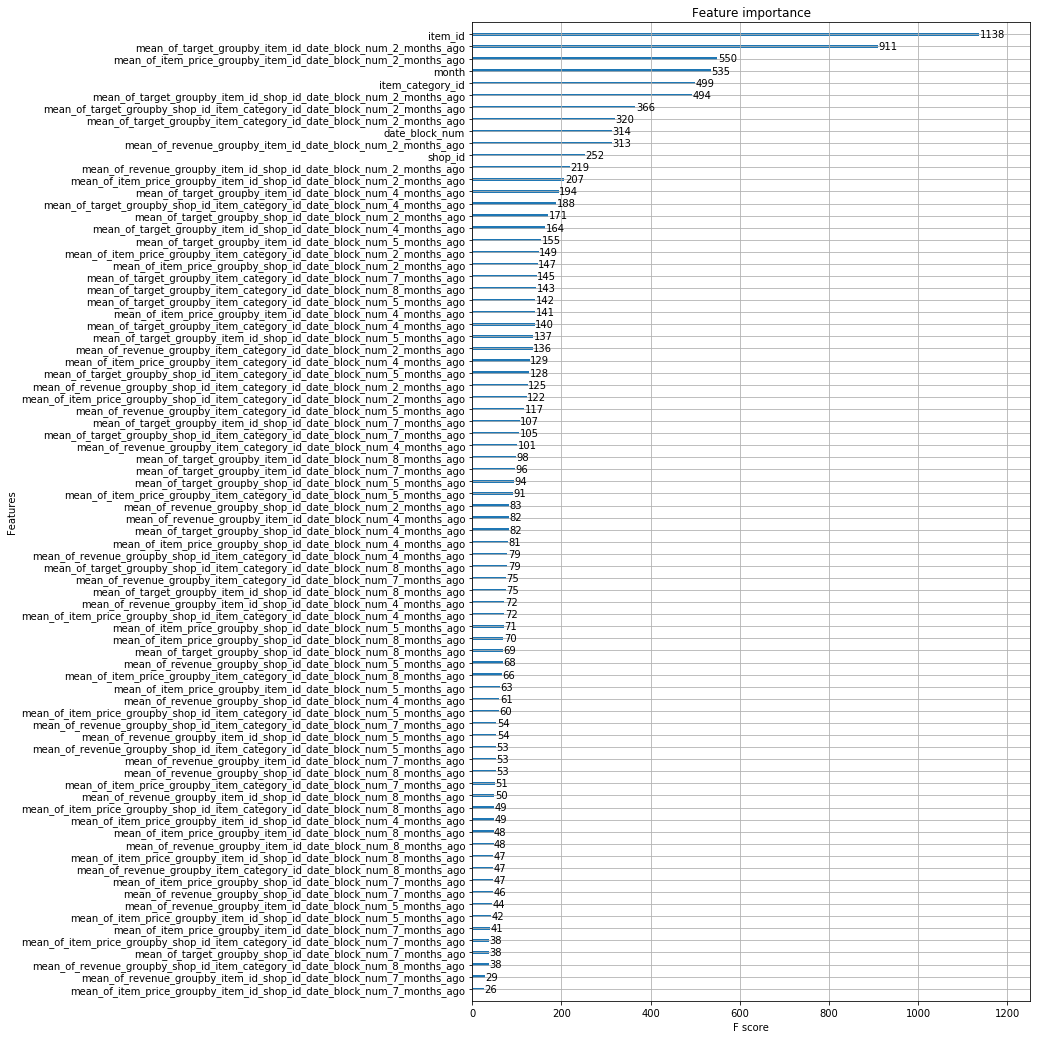

In [66]:
# For lags = [2,4,5,7,8]
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax)

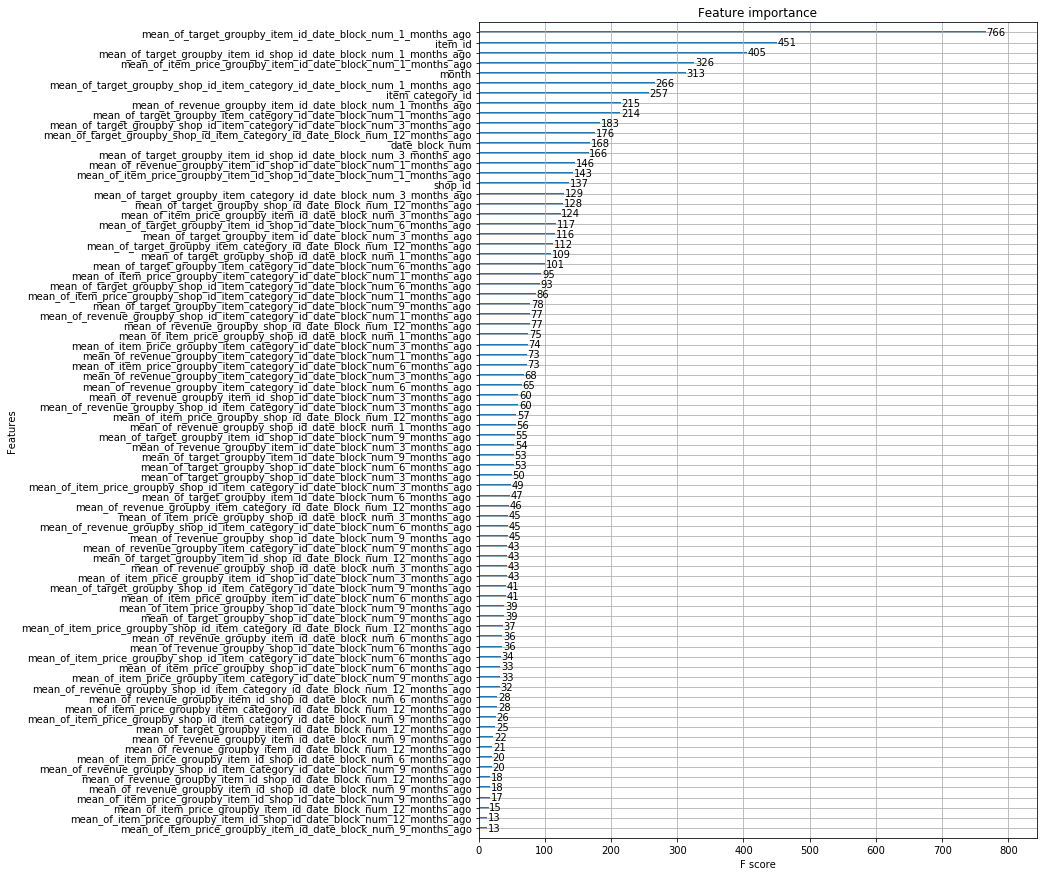

In [75]:
# For lags = [1,3,6,9,12]
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);